#  <font color='firebrick'> Data Driven Customer Segmentation Using Clustering Techniques

**Learning Objectives**

By the end of this module, you will be able to to:

- Describe the advantages of using unsupervised learning techniques (clustering) over more traditional segmentation techniques
- Perform the preprocessing steps for preparing data for clustering
- Use k-means clustering to perform customer segmentation
- Determine the properties of groups created using clustering
- Tune hyperparameters (such as the number of clusters) of clustering algorithms using various methods

**Sources:** 

- Data Science for Marketing Analytics, by Tommy Blanchard, Debasish Behera, and Pranshu Bhatnagar. Packt Publishing, 2019. (USC library has an electronic version of the book)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn import cluster


## <font color='firebrick'> What is customer segmentation?

Customer segmentation is the act of separating (segmenting) your target customers into different groups based on demographic or behavioral data so that marketing strategies can be tailored more specifically to each group.

*Traditional Segmentation Methods*

- The most common general method is for a marketing analyst to sit down with the data they have about customers, whether it's demographic or behavioral, and to try to come up with rough groupings based on intuitions and arbitrary thresholds. An example of this would be deciding to segment customers into different income tiers, based on \$10,000 increments.

- This becomes more important when looking at the behavioral data of customers. Creating groups based on intuition can result in underlying patterns in the data being overlooked. For example, there may be segments of the population that respond well to very specific kinds of marketing offers. If the analyst performing the segmentation doesn't happen to know about this specific group and the types of ads they respond to, they may miss out on capturing them as a unique group. For instance, a marketing analyst who separates customers into those who respond to offers for expensive products and those who respond to offers for inexpensive products could miss a group of customers only interested in electronics, regardless of whether they are expensive or inexpensive.

*Data Driven Segmentation Methods*

- Another method for performing customer segmentation is using clustering techniques. Using clustering is often a very powerful technique as it tends to pick up on patterns in data that might otherwise be missed. It's perfect for customer segmentation because it finds data points that are **similar** or most like each other and groups them together, which is exactly what good customer segmentation techniques should do. For a clustering algorithm to try to find groups of customers, they need some measure of what it means for a customer to be similar or different.

- Ideally, each feature you choose should have roughly equal importance in your mind in terms of how well it captures something important about the customer. For example, segmenting customers based on the flavor of toothpaste they tend to buy may not make sense if you want to design marketing strategies for selling cars.

- Customer behavior, such as how they have responded to marketing campaigns in the past, is often the most relevant kind of data. However, in the absence of this, it's often useful to segment customers based on other traits, such as their income and age.


## <font color='firebrick'> Standardizing data

- *Standardizing data*: To be able to group customers based on continuous variables, we first need to rescale these parameters such that the data is on similar scales. Take age and income, for instance. These are on very different scales. It's not uncommon to see incomes that are different by \$10,000, but it would be very odd to see two people whose ages differed by 10,000 years. Therefore, we need to be explicit about how big a change in one of these variables is about the same as changing the others in terms of customer similarity. For example, we might say that a difference of 10 years of age between two customers makes those two customers as different for our purposes as if they had an income disparity of 10,000 dollars. However, making these kinds of determinations manually for each variable would be difficult. This is the reason why we typically standardize the data, to put them all on a standard scale.

- We compute z-scores for the variables to standardize the data

In [2]:
# In this example we will simulate customer data (age and income)

#set random seed to 100 so that you get the same "random" output as in this Jupyter notebook
np.random.seed(100)

#initialize an empty dataframe
df = pd.DataFrame()

# https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html 
# loc: mean; scale: standard deviation; size: number of random values
df['income'] = np.random.normal(loc = 50000, scale = 10000, size = 100)
df['age'] = np.random.normal(40, 10, 100)

# convert the values in the dataframe to integers to get whole numbers
df = df.astype(int)
df.head()

,income,age
0,32502,22
1,53426,28
2,61530,10
3,47475,40
4,59813,37


In [3]:
df.describe().round()

,income,age
count,100.0,100.0
mean,48958.0,39.0
std,9746.0,11.0
min,25128.0,10.0
25%,41526.0,32.0
50%,49634.0,38.0
75%,56762.0,46.0
max,70346.0,62.0


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


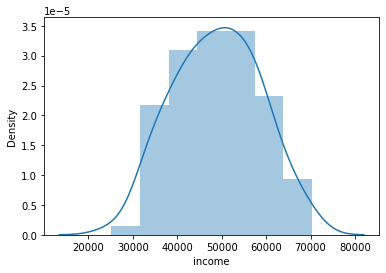

In [4]:
# check the distribution of income
sns.distplot(df['income'])

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


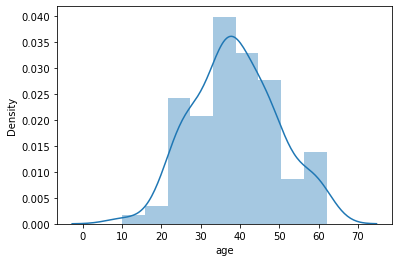

In [5]:
# check the distribution of age
sns.distplot(df.age)

In [6]:
# standardize both income and age

df['z_income'] = (df['income'] - df['income'].mean())/df['income'].std()
df['z_age'] = (df['age'] - df['age'].mean())/df['age'].std()

df.head()

,income,age,z_income,z_age
0,32502,22,-1.688402,-1.575147
1,53426,28,0.458441,-1.011588
2,61530,10,1.289927,-2.702265
3,47475,40,-0.152143,0.115530
4,59813,37,1.113759,-0.166250


In [7]:
df.describe().round()

,income,age,z_income,z_age
count,100.0,100.0,100.0,100.0
mean,48958.0,39.0,0.0,-0.0
std,9746.0,11.0,1.0,1.0
min,25128.0,10.0,-2.0,-3.0
25%,41526.0,32.0,-1.0,-1.0
50%,49634.0,38.0,0.0,-0.0
75%,56762.0,46.0,1.0,1.0
max,70346.0,62.0,2.0,2.0


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

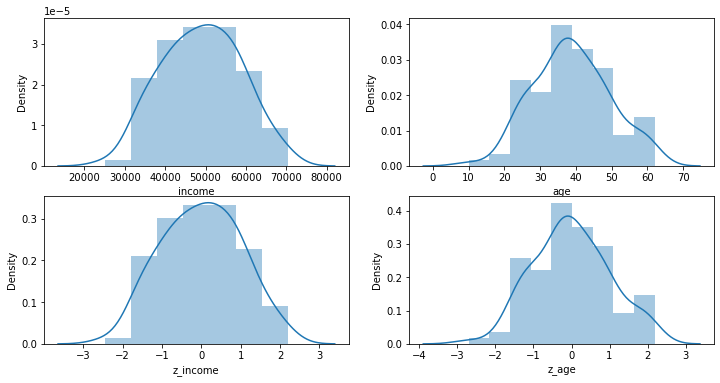

In [8]:
# put all 4 plots on one graph
# https://matplotlib.org/devdocs/gallery/subplots_axes_and_figures/subplots_demo.html

# notice that the raw data preserves its distribution shape after standardization

fig, ax = plt.subplots(2,2, figsize = (12, 6))

sns.distplot(df['income'], ax = ax[0,0])
sns.distplot(df['age'], ax = ax[0,1])
sns.distplot(df['z_income'], ax = ax[1,0])
sns.distplot(df['z_age'], ax = ax[1,1])

## <font color='firebrick'> Calculating distance

Once the data is standardized, we need to calculate the similarity between customers. Typically, this is done by calculating the distance between the customers in the feature space. In a two-dimensional scatterplot, the Euclidean distance between two customers is just the distance between their points.

Suppose that we have the following three customers. Which of them are more similar to each other?

|Customer | Age (in years) | Income (in USD)|
|---------|----------------|----------------|
|1 | 40 | \$40,000|
|2 | 35 | \$30,000|
|3 | 30 | \$45,000|

#### Computing Similarities between Customers

In [9]:
ages = [40, 35, 30]
incomes = [40000, 30000, 45000]

In [10]:
# distance between customer 1 and 2
d12 = math.sqrt((ages[0]-ages[1])**2 + (incomes[0]-incomes[1])**2)

# distance between customer 1 and 3
d13 = math.sqrt((ages[0]-ages[2])**2 + (incomes[0]-incomes[2])**2)

# distance between customer 2 and 3
d23 = math.sqrt((ages[1]-ages[2])**2 + (incomes[1]-incomes[2])**2)



In [11]:
print("Customer 1 & 2:", d12, 
      "\nCustomer 1 & 3:", d13, 
      "\nCustomer 2 & 3:", d23)

Customer 1 & 2: 10000.001249999921 
Customer 1 & 3: 5000.00999999 
Customer 2 & 3: 15000.00083333331


Before standardization, we see the customers 1 and 2 are the most similar. Let' see if this will be the case after standardization. 

#### Computing Similarities between customers (with standardization)

In [12]:
ages = pd.Series([40, 35, 30]) #Change to pandas Series for easier computation of the mean
income = pd.Series([40000, 30000, 45000])

z_ages = [(i- ages.mean())/ages.std() for i in ages]
z_income = [(i - income.mean())/income.std() for i in income]

df = pd.DataFrame({'age': ages, 'income':income, 'z_age':z_ages, 'z_income':z_income})
df

,age,income,z_age,z_income
0,40,40000,1.0,0.218218
1,35,30000,0.0,-1.091089
2,30,45000,-1.0,0.872872


In [13]:
# distance between customer 1 and 2
z_d12 = math.sqrt((z_ages[0]-z_ages[1])**2 + (z_income[0]-z_income[1])**2)

# distance between customer 1 and 3
z_d13 = math.sqrt((z_ages[0]-z_ages[2])**2 + (z_income[0]-z_income[2])**2)

# distance between customer 2 and 3
z_d23 = math.sqrt((z_ages[1]-z_ages[2])**2 + (z_income[1]-z_income[2])**2)

In [14]:
print("Customer 1 & 2:", z_d12, 
      "\nCustomer 1 & 3:", z_d13, 
      "\nCustomer 2 & 3:", z_d23)

Customer 1 & 2: 1.647508942095828 
Customer 1 & 3: 2.104417123236605 
Customer 2 & 3: 2.203892660077359


In [15]:
# let's compare distance vs. standardized distances 

dist = pd.DataFrame({'Distance': pd.Series([d12, d13, d23]),
               'Standardized Distance': pd.Series([z_d12, z_d13, z_d23])})
dist.index = ['1 & 2', '1 & 3', '2 & 3']

dist

,Distance,Standardized Distance
1 & 2,10000.001250,1.647509
1 & 3,5000.010000,2.104417
2 & 3,15000.000833,2.203893


With standardization, we notice that customers 1 & 2 are more similar compared to 1 & 3, 2  & 3.

### <font color='blue'> DIY

The dataset `customer_interactions.csv` contains data the amount spent by customers on your products and the number of times they have interacted with your business (for instance, by visiting your website). 

- Standardize both variables `spend` and `interactions`.
- Consider a random sample of 3 customers (use a seed of 100 to get similar results in this Jupyter notebook. You can use the sample() method in pandas. Check online on how you can control the 'random' outcome in sample())
- Which two customers are the closest to each other?

In [16]:
data = pd.read_csv('customer_interactions.csv')
data.head()

,spend,interactions
0,5818,23
1,6255,15
2,6139,15
3,6070,19
4,4837,24


In [17]:
data['z_spend'] = (data['spend'] - data['spend'].mean())/data['spend'].std()
data['z_interactions'] = (data['interactions'] - data['interactions'].mean())/data['interactions'].std()

data.head()

,spend,interactions,z_spend,z_interactions
0,5818,23,0.923351,0.647282
1,6255,15,1.145958,-0.809740
2,6139,15,1.086868,-0.809740
3,6070,19,1.051719,-0.081229
4,4837,24,0.423632,0.829410


In [18]:
# get a sample of 3 customers

s_data = data.sample(3, random_state = 100).reset_index()
s_data

,index,spend,interactions,z_spend,z_interactions
0,249,3144,20,-0.438778,0.100899
1,353,3330,25,-0.344030,1.011538
2,537,2615,26,-0.708249,1.193666


In [19]:
# distance between customer 1 and 2
z_d12 = math.sqrt((s_data.loc[0,'z_spend'] - s_data.loc[1,'z_spend'])**2 + (s_data.loc[0,'z_interactions'] - s_data.loc[1,'z_interactions'])**2)

# distance between customer 1 and 3
z_d13 = math.sqrt((s_data.loc[0,'z_spend'] - s_data.loc[2,'z_spend'])**2 + (s_data.loc[0,'z_interactions'] - s_data.loc[2,'z_interactions'])**2)

# distance between customer 2 and 3
z_d23 = math.sqrt((s_data.loc[1,'z_spend'] - s_data.loc[2,'z_spend'])**2 + (s_data.loc[1,'z_interactions'] - s_data.loc[2,'z_interactions'])**2)

In [20]:
print("Customer 1 & 2:", z_d12, 
      "\nCustomer 1 & 3:", z_d13, 
      "\nCustomer 2 & 3:", z_d23)

Customer 1 & 2: 0.915554870633757 
Customer 1 & 3: 1.1255017901324251 
Customer 2 & 3: 0.4072175989496995


## <font color='firebrick'> k-means clustering

k-means clustering is a very common unsupervised learning technique with a very wide range of applications. It is powerful because it is conceptually relatively simple, scales to very large datasets, and tends to work quite well in practice. 

k-means clustering is an algorithm that tries to find the best way of grouping data points into k different groups, where k is a parameter given to the algorithm. For now, we will choose k arbitrarily. We will revisit how to choose k in practice in the next chapter. The algorithm then works iteratively to try to find the best grouping. There are two steps to this algorithm:

1. The algorithm begins by randomly selecting k points in space to be the centroids of the clusters. Each data point is then assigned to the centroid that it is closest to it.
2. The centroids are updated to be the mean of all of the data points assigned to them. The data points are then reassigned to the centroid closest to them.

Step two is repeated until none of the data points change the centroid they are assigned to after the centroid is updated.

One point to note here is that this algorithm is not deterministic, that is, the outcome of the algorithm depends on the starting locations of the centroids. Therefore, it is not always guaranteed to find the best grouping. However, in practice it tends to find good groupings while still being computationally inexpensive even for large datasets. k-means clustering is fast and easily scalable, and is therefore the most common clustering algorithm used.

In [21]:
# read ageinc.csv data

data = pd.read_csv('ageinc.csv')
data.sample(2)

,income,age
157,39522,35
250,55978,27


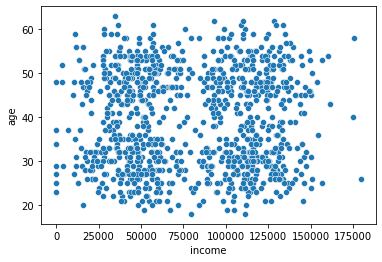

In [22]:
# let's create a scatterplot for income and age

sns.scatterplot(data = data, x = 'income', y = 'age')

In [23]:
# In order to run k-means clustering, we need to standardize the numerical data

data['z_income'] = (data['income'] - data['income'].mean())/data['income'].std()
data['z_age'] = (data['age'] - data['age'].mean())/data['age'].std()

data.sample(2)

,income,age,z_income,z_age
643,3384,52,-1.954362,1.146963
176,102206,47,0.562605,0.691458


In [24]:
# let's check if the standardization is computed correctly
# we expect the mean of z_income and z_age to be 0, 
# we expect the standard deviation for z_income and z_age to be 1

data[['z_income', 'z_age']].mean()

z_income    2.842171e-17
z_age       2.906009e-16
dtype: float64

In [25]:
data[['z_income', 'z_age']].std()

z_income    1.0
z_age       1.0
dtype: float64

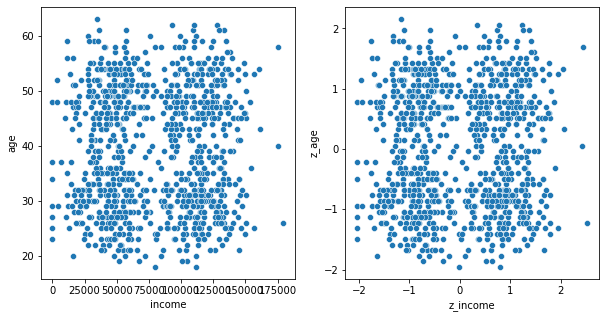

In [26]:
# let's check the scatter plot for the standardized data 

fig, ax = plt.subplots(1,2, figsize = (10, 5))

sns.scatterplot(data = data, x = 'income', y = 'age', ax = ax[0])
sns.scatterplot(data = data, x = 'z_income', y = 'z_age', ax = ax[1])

In [27]:
# run k-means clustering

# create a k-means model with 4 clusters (the random_state is needed so that 
# everyone gets the same answer in this notebook because Kmeans clustering is 
# not deterministic). The initial assingment of points as centroids is done randomly
model = cluster.KMeans(n_clusters = 4, random_state = 10)
#fit the created k-means model to our data
model.fit(data[['z_income', 'z_age']])

KMeans(n_clusters=4, random_state=10)

In [28]:
# the model fit has an attribute called 'labels_' which stores 
# a number that represents the cluster of each point in the dataset
# since we created a k-means model with k=4 (n_clusters), then we will 
# see labels 0, 1, 2, and 3.
model.labels_

array([2, 3, 1, 1, 1, 3, 3, 0, 3, 1, 3, 3, 3, 2, 2, 1, 0, 0, 3, 1, 3, 0,
       2, 2, 3, 0, 2, 3, 2, 0, 3, 3, 3, 0, 0, 0, 3, 3, 1, 2, 1, 1, 2, 0,
       0, 0, 2, 2, 0, 3, 0, 1, 2, 3, 1, 3, 3, 3, 0, 3, 2, 1, 0, 0, 3, 0,
       1, 0, 2, 0, 1, 0, 0, 2, 1, 1, 3, 0, 0, 2, 2, 3, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 3, 1, 0, 3, 3, 0, 1, 1, 1, 3, 0, 1, 2, 1, 3, 0, 1, 1, 1,
       3, 2, 2, 3, 0, 1, 2, 0, 3, 1, 2, 3, 0, 3, 1, 3, 0, 3, 3, 2, 0, 3,
       1, 0, 2, 1, 0, 3, 2, 3, 1, 3, 1, 0, 3, 1, 2, 0, 0, 3, 0, 3, 0, 1,
       3, 3, 0, 3, 0, 2, 2, 0, 2, 0, 2, 3, 3, 2, 0, 3, 0, 1, 0, 2, 1, 1,
       2, 2, 0, 0, 1, 3, 0, 3, 2, 0, 0, 2, 2, 0, 0, 1, 3, 3, 3, 3, 2, 0,
       2, 1, 2, 1, 1, 3, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 3, 0, 3, 2, 1,
       0, 0, 3, 0, 0, 2, 1, 3, 1, 2, 2, 1, 2, 0, 3, 0, 3, 2, 3, 2, 2, 1,
       3, 0, 1, 2, 2, 3, 3, 0, 3, 3, 3, 1, 1, 1, 0, 0, 2, 0, 0, 3, 2, 0,
       3, 2, 2, 3, 0, 1, 1, 0, 3, 2, 2, 2, 3, 3, 2, 2, 2, 0, 3, 2, 0, 2,
       1, 3, 1, 3, 3, 1, 2, 0, 3, 0, 1, 0, 2, 3, 0,

In [29]:
# add a cluster column to our dataset

data['cluster'] = model.labels_
data.head()

,income,age,z_income,z_age,cluster
0,101743,58,0.550812,1.693570,2
1,49597,27,-0.777331,-1.130565,3
2,36517,52,-1.110474,1.146963,1
3,33223,49,-1.194372,0.873660,1
4,72994,53,-0.181416,1.238064,1


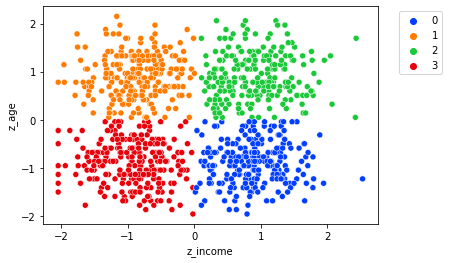

In [30]:
#for colors and palettes
#http://seaborn.pydata.org/tutorial/color_palettes.html
sns.scatterplot(data = data, 
                x = 'z_income', 
                y = 'z_age', 
                hue = 'cluster', 
                palette = 'bright')

# the following line of code puts the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)


We see from the plot above that we have 4 segments of customers:

- young with low income (orange)
- young with high income (red)
- old with low income (green)
- old with high income (blue)

## <font color='firebrick'> k-means Clustering on high-dimensional data

It's common to have data that has more than just two dimensions. For example, if in our age and income data we also had yearly spend, we would have three dimensions. If we had some information about how these customers responded to advertised sales, or how many purchases they had made of our products, or how many people lived in their household, we could have many more dimensions.

When we have additional dimensions, it becomes more difficult to visualize our data. In the previous exercise, we only had two variables, and so we could easily visualize data points and the clusters formed. With higher dimensional data, however, different techniques need to be used. Dimensionality reduction techniques are commonly used for this. However, here, we will focus on a very popular technique called "The Elbow plot".

Perform k-means clustering on the `three_col.csv`:

#### k-means clustering on high-dimensional data

In [31]:
#read the data
data = pd.read_csv('three_col.csv')
data.sample(3)

,income,age,days_since_purchase
373,42835,38,574
907,131581,18,240
565,33195,20,553


In [32]:
# standardize the data
# now that we have more than 2 columns, it will be exhausting to standaradize each 
# column seperately. Technically, we are doing the same task of standardization 3 times
# and if we have 100 columns, then we will need to do it 100 times. 
# For loops help when we are reapting the same compuation multiple times just as we have hear

# save the column names in a variable called col_names so we can loop on
col_names = data.columns

# create a list of the standardized column names
#z_cols = ['z'+col for col in col_names]

for col in col_names:
    data['z_'+ col] = (data[col] - data[col].mean())/data[col].std()

    
data.sample(3)

,income,age,days_since_purchase,z_income,z_age,z_days_since_purchase
153,38710,52,315,-1.068230,1.091289,-0.774041
759,119370,38,238,1.031776,-0.135469,-1.466763
487,105629,51,467,0.674025,1.003663,0.593411


In [33]:
# check if we standardize correctly
data.describe()

,income,age,days_since_purchase,z_income,z_age,z_days_since_purchase
count,1000.000000,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1.000000e+03
mean,79740.087000,39.546000,401.039000,1.598721e-17,5.928591e-17,1.341149e-16
std,38409.400293,11.412192,111.155625,1.000000e+00,1.000000e+00,1.000000e+00
min,0.000000,18.000000,139.000000,-2.076057e+00,-1.887981e+00,-2.357407e+00
25%,45311.250000,30.000000,299.000000,-8.963649e-01,-8.364738e-01,-9.179832e-01
50%,81676.000000,40.000000,403.000000,5.040206e-02,3.978202e-02,1.764193e-02
75%,113400.500000,50.000000,502.000000,8.763587e-01,9.160379e-01,9.082851e-01
max,168993.000000,65.000000,630.000000,2.323726e+00,2.230422e+00,2.059824e+00


In [34]:
# perform k-means clustering

model= cluster.KMeans(n_clusters = 4, random_state = 10)
#fit the created k-means model to our data
model.fit(data[['z_income', 'z_age', 'z_days_since_purchase']])

data['cluster'] = model.labels_

We can investigate what each cluster seems to be capturing, by looking at the means of each of the variables in each cluster:

In [35]:
data.sample(2)

,income,age,days_since_purchase,z_income,z_age,z_days_since_purchase,cluster
886,60357,33,453,-0.504644,-0.573597,0.467462,1
333,134878,57,496,1.435532,1.529417,0.854307,3


In [36]:
data[['income', 'age', 'days_since_purchase', 'cluster']].groupby('cluster').mean().astype(int)

,income,age,days_since_purchase
cluster,,,
0,114704,29,302
1,46153,29,498
2,45002,49,299
3,113118,49,502


We see from the plot above that we have 4 segments of customers:

- young with low income, and long time since purchase (blue)
- old with low income, and short time since purchase (orange)
- old with high income, and long time since purchase (green)
- young with high income, and short time since purchase (red)


<IPython.core.display.Javascript object>


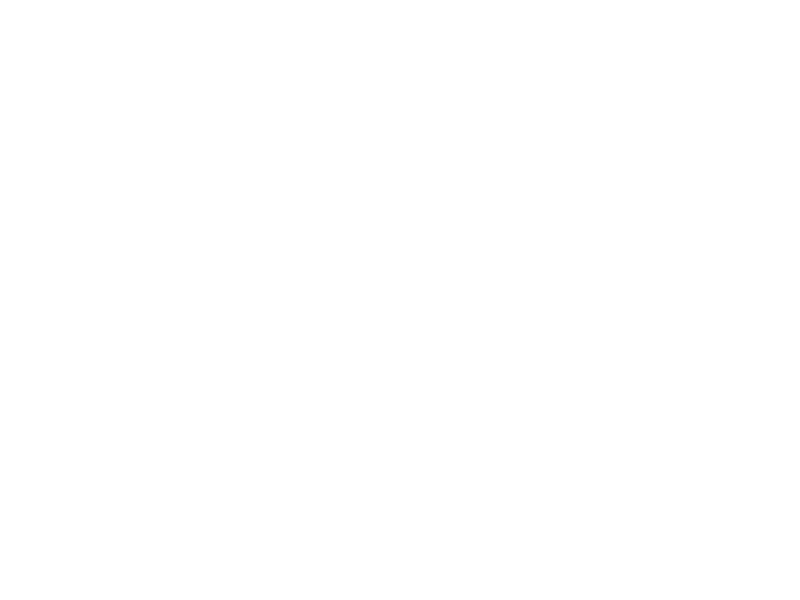

In [37]:
%matplotlib notebook

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(data['income'],
           data['age'],
           data['days_since_purchase'], 
           c='r', 
           marker='o')

ax.set_xlabel('Income')
ax.set_ylabel('Age')
ax.set_zlabel('Days since purchase')

plt.show()


<IPython.core.display.Javascript object>


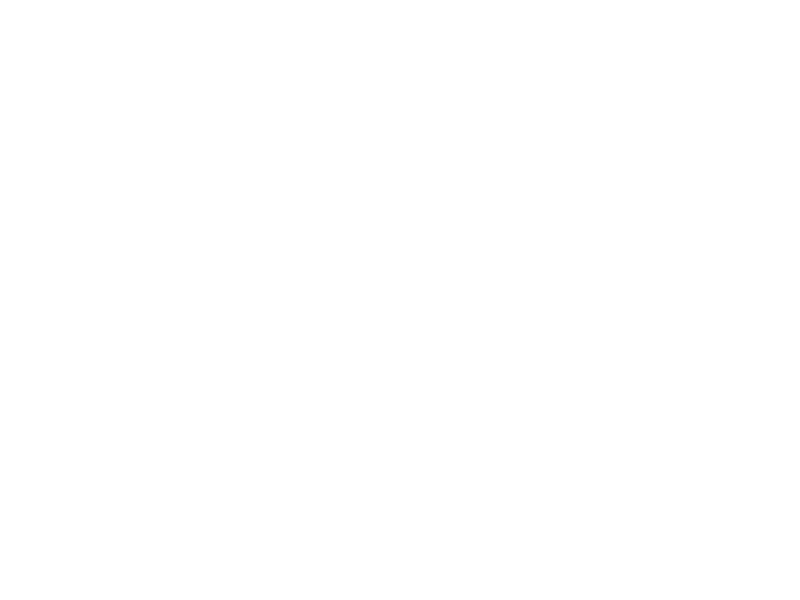

In [38]:
%matplotlib notebook

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(data['income'],
           data['age'],
           data['days_since_purchase'],
           c= data['cluster'], 
           marker='o')

ax.set_xlabel('Income')
ax.set_ylabel('Age')
ax.set_zlabel('Days since purchase')

plt.show()

##  <font color='firebrick'> Choosing the number of clusters using the Elbow Method

Often, it’s difficult to tell by visualization alone how many clusters should be used for a particular problem. Different people may disagree about the number of clusters to use, and there may not be a clear answer. Furthermore, dimensionality-reduction techniques are not perfect—they attempt to take all the information in multiple dimensions and reduce it to only two. In some cases, this can work well, but as the number of dimensions increases, the data becomes more complex, and these visual methods quickly reach their limitations. When this happens, it’s not easy to determine through visual inspection what the right number of clusters to use is. In these harder cases, it’s often better to reach for a more quantitative measure. One such classic measure is to look for an elbow in a plot of the sum of squared errors.

The sum of squared errors is the sum of the "errors" (difference between a data point and the centroid of its assigned cluster) for all data points, squared. It can be calculated with the following equation:

$SS = \sum\limits_{k}\sum\limits_{x_i \in k} (x_i - \mu_k)^2$


Here, $\mu_k$ is the location of the centroid of cluster k, and each $x_i$ is a data point assigned to cluster k. As we increase k, we should expect the sum of squared errors to decrease since there are more centroids. When plotted together, however, there will often be an "elbow" in the plot, where the "gain" in terms of reduced errors seems to slow for each new cluster. Hence, the plot of the sum of squared errors versus number of clusters (k) will look as follows:

In [39]:
data.head()

,income,age,days_since_purchase,z_income,z_age,z_days_since_purchase,cluster
0,56432,31,492,-0.606833,-0.748848,0.818321,1
1,137580,38,551,1.505879,-0.135469,1.349109,3
2,68285,59,304,-0.298237,1.704668,-0.873001,2
3,93617,51,507,0.361289,1.003663,0.953267,3
4,113441,54,509,0.877413,1.266540,0.971260,3


In [40]:
# drop the cluster column
data = data.drop('cluster', axis = 1)

In [41]:
data.head(2)

,income,age,days_since_purchase,z_income,z_age,z_days_since_purchase
0,56432,31,492,-0.606833,-0.748848,0.818321
1,137580,38,551,1.505879,-0.135469,1.349109


In [42]:
# We will start with k=2 and compute the Sum of Squares

model = cluster.KMeans(n_clusters=2, random_state=10)

clusters = model.fit_predict(data[['z_income','z_age']])
data['cluster'] = clusters
centers = model.cluster_centers_

# compute sum of squares
model.inertia_

1189.9242519178374

In [43]:
# now, let's do it for all values of k between 2 and 10

#define an empty list to hold all sum of squares (ss)
ss = []

for i in range(2, 11):
    
    model = cluster.KMeans(n_clusters=i, random_state=10)

    clusters = model.fit_predict(data[['z_income','z_age']])
    data['cluster'] = clusters
    centers = model.cluster_centers_
    ss.append(model.inertia_)

print(ss)

[1189.9242519178376, 732.4984352223842, 386.878365188152, 342.7669155987485, 305.5819448280657, 268.6909125324156, 239.69865259061598, 216.25116218115585, 195.9935581242904]


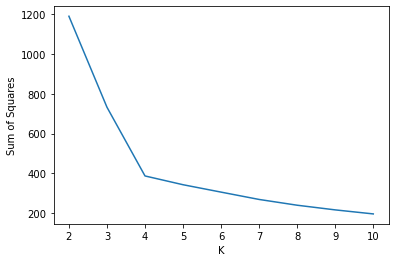

In [44]:
%matplotlib inline

# plot the elbow plot

data = pd.DataFrame({'K': range(2,11), 
                      'Sum of Squares':ss})

sns.lineplot(data = data, 
             x = 'K', 
             y = 'Sum of Squares')

By observing the preceding plot, you will notice that there’s a clear elbow in the plot at k=4, so we take that as our best number for k. Prior to that, an additional cluster gives us big gains in reducing the sum of squared errors. Beyond that, we seem to be getting diminishing returns.

Text(0.5, 1.0, 'Elbow Plot')

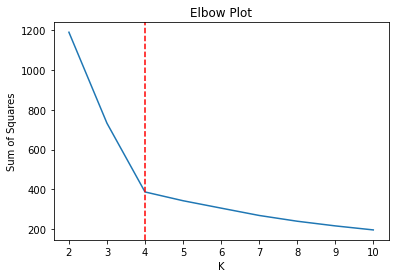

In [45]:
sns.lineplot(data = data, 
             x = 'K', 
             y = 'Sum of Squares')

plt.axvline(x = 4, color = 'red', linestyle = '--')
plt.title('Elbow Plot')